In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


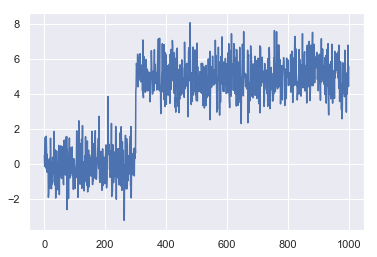

In [46]:
def make_data(N, f =0.3, rseed=1):
    rand = np.random.RandomState(42)
    x = rand.randn(N)
    x[int(f*N):] += 5
    return x
x = make_data(1000)
plt.plot(x)

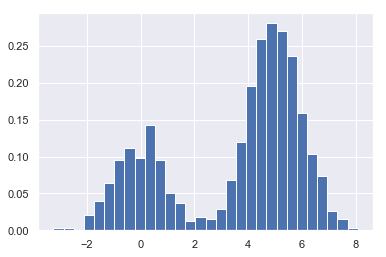

In [48]:
hist = plt.hist(x, bins = 30, density = True)

In [63]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density*widths).sum()

1.0000000000000002

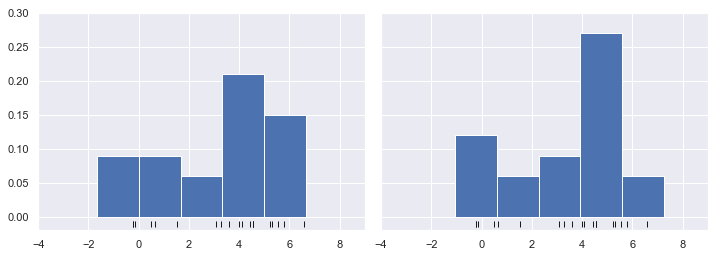

In [65]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(1,2, figsize=(12,4),
                      sharex = True, sharey=True,
                      subplot_kw={'xlim': (-4, 9),
                                  'ylim': (-0.02, 0.3)})
fig.subplots_adjust(wspace = 0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins = bins +offset, density = True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  6.57921282  5.76743473  4.53052561  5.54256004  4.53658231  4.53427025
  5.24196227  3.08671976  3.27508217  4.43771247  3.98716888  5.31424733
  4.09197592  3.5876963 ]


(-0.2, 8)

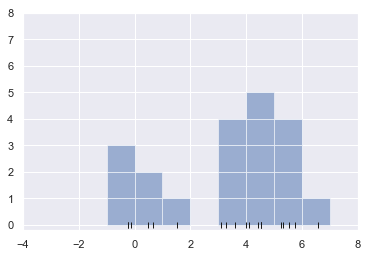

In [74]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
print(x)
ax.plot(x, np.full_like(x, 0), '|k')
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha =0.5))
ax.set_xlim(-4,8)
ax.set_ylim(-0.2, 8)

[-2, 8, -0.2, 8]

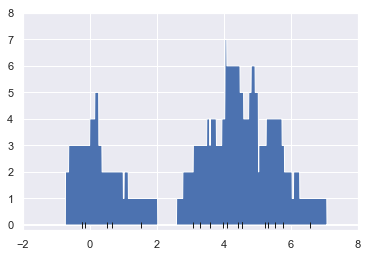

In [115]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) <0.5) for xi in x)
plt.fill_between(x_d, density)
plt.plot(x, np.full_like(x,0), '|k')
plt.axis([-2, 8, -0.2, 8])

[-2, 8, -0.2, 8]

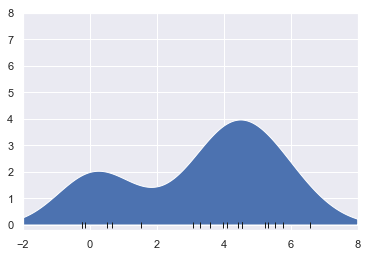

In [130]:
#We use standart nornal curve at each point instead block
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d)for xi in x)

plt.fill_between(x_d, density)
plt.plot(x, np.full_like(x,0), '|k')

plt.axis([-2, 8, -0.2, 8])

### Kernel Density Estimation in Practice

In [162]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity
bandwidths = 10 ** np.linspace(-1, 1, 100)

grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    [{'bandwidth': bandwidths}],
                    cv=LeaveOneOut().get_n_splits(x))
grid.fit(x[:, None])

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [163]:
grid.best_params_

{'bandwidth': 0.7742636826811272}

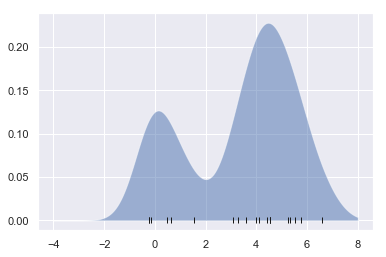

In [168]:
kde = KernelDensity(bandwidth=0.7, kernel = 'gaussian')
kde.fit(x[:, None])

logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha = 0.5)
plt.plot(x, np.full_like(x, 0), '|k')


### Not So Naive Bayes

In [173]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters 
    --------
    bandwidth : float
        the kernek bandwidth
    kernel : str
        the kernel name
    """
    def __init__(self, bandwidth=1, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel = self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self
    
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims = True)
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
    
        

In [177]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]


D:\Anaconda_3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [ ]:
plt.semilogx(bandwidths, scores)
plt.xlabel('band')
plt.ylabel('accuracy')
plt.title("KDE Model Perfomance")